In [24]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [25]:
house_data_path = 'dataset/housing.csv'
housing_df = pd.read_csv(house_data_path)

In [26]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [27]:
housing_df.info()
# total_bedrooms has 20640 - 20433 = 207 missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
housing_df['ocean_proximity'].value_counts()
# This column is categorical, so we need to convert it to numerical values

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [29]:
housing_df['ocean_proximity'] = housing_df['ocean_proximity'].astype('category').cat.codes

In [30]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,1.165843
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,1.420662
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


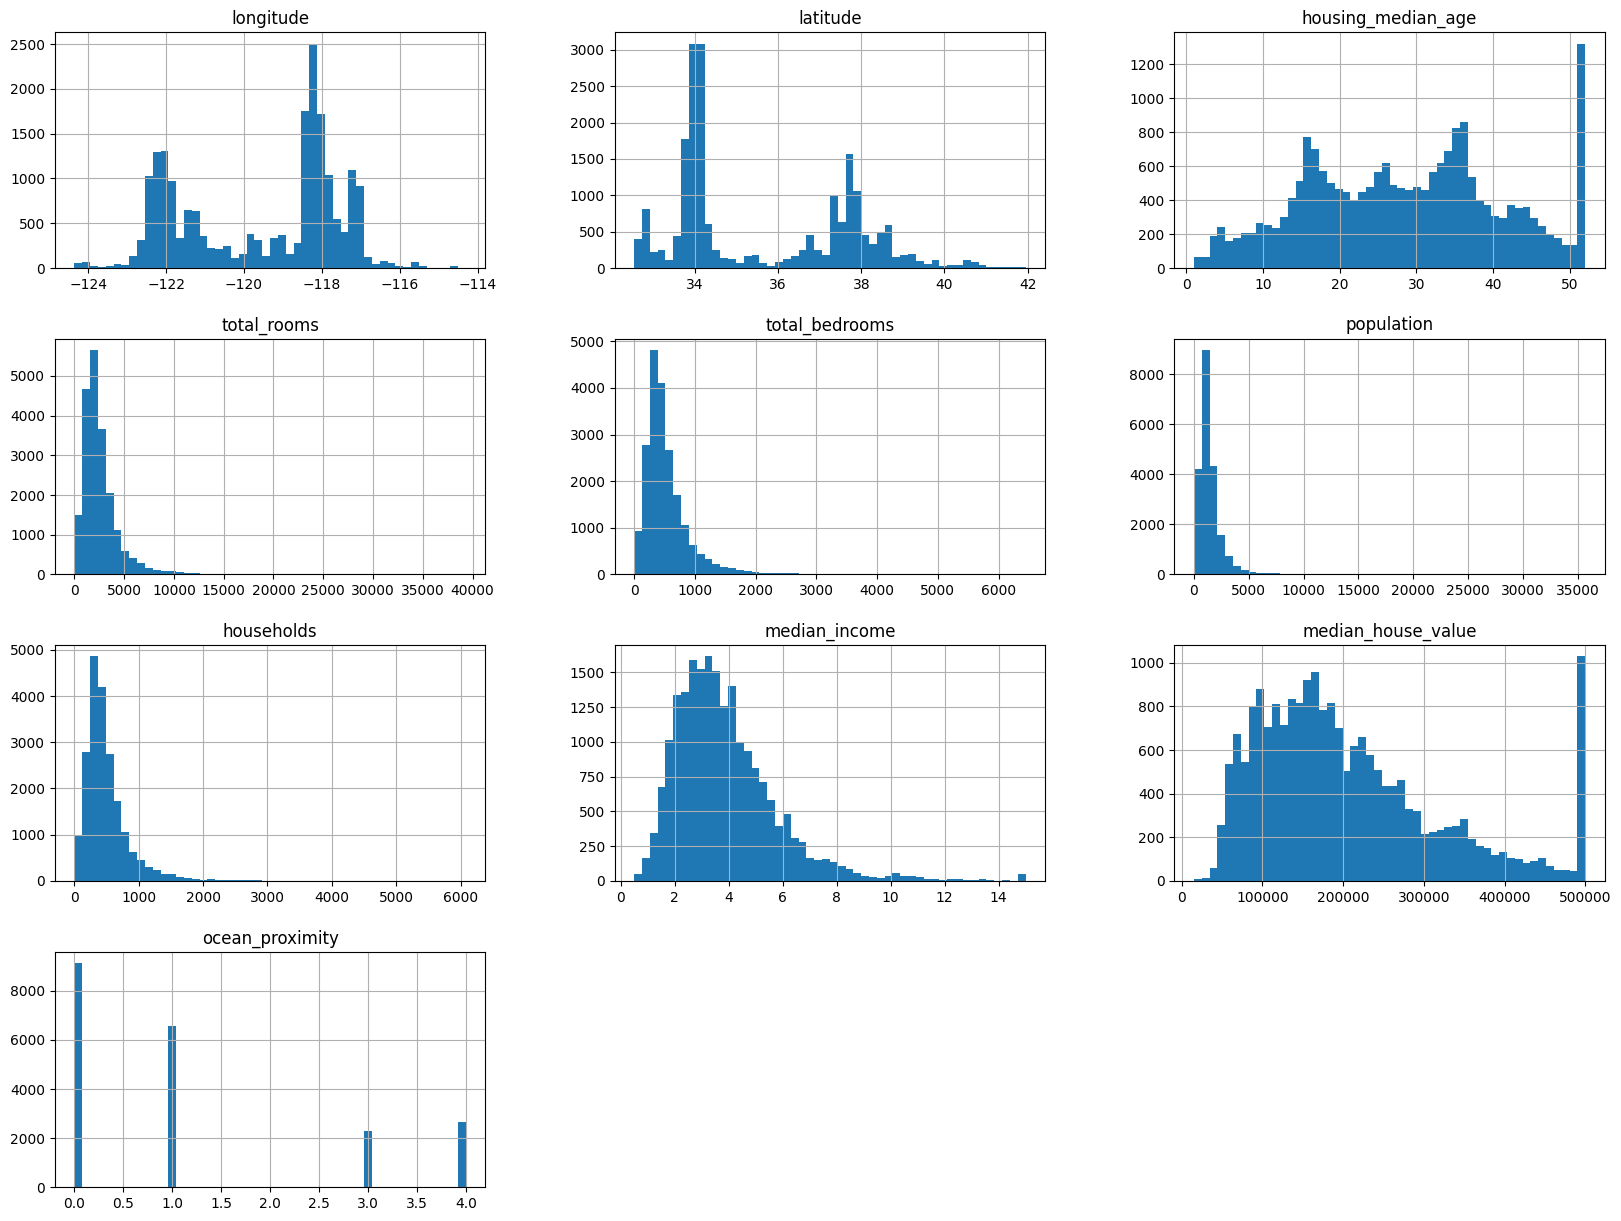

In [31]:
# let's visualize the data and check for any anomalies
housing_df.hist(figsize=(20,15), bins=50)
plt.show()

# median_income is not normally distributed, so we will use log transformation
# housing_median_age and median_house_value are artificially capped at 52 and 500000 respectively
# total_rooms, total_bedrooms, population, households have a tail heavy distribution ( need to adjust the scale )

In [32]:
# prepare dataset

train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

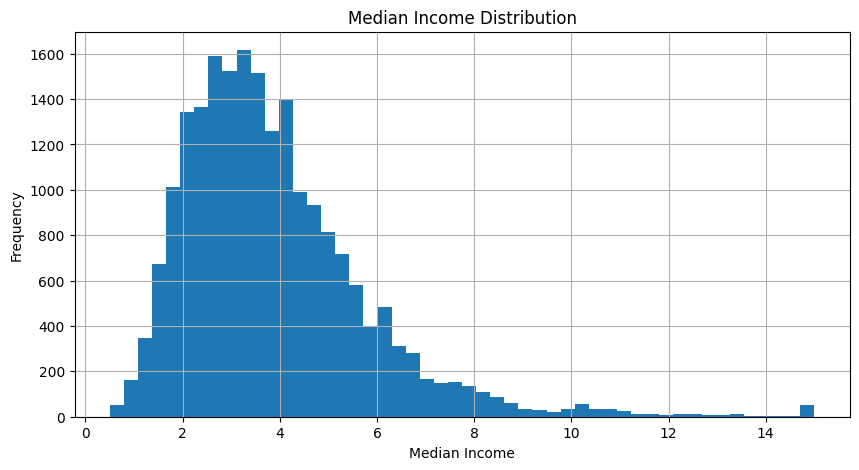

In [33]:
housing_df['median_income'].hist(bins=50, figsize=(10,5))
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.title('Median Income Distribution')
plt.show()

In [34]:
housing_df['income_cat'] = pd.cut(housing_df['median_income'], # use column median_income
                                      bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], # create bins from 0 to infinity
                                      labels=[1, 2, 3, 4, 5]) # assign labels to the bins

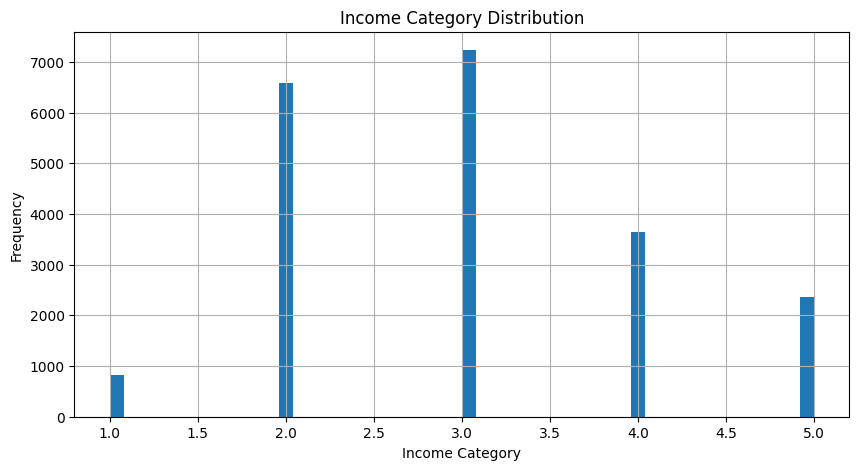

In [35]:
housing_df['income_cat'].hist(bins=50, figsize=(10,5))
plt.xlabel('Income Category')
plt.ylabel('Frequency')
plt.title('Income Category Distribution')
plt.show()

In [36]:
# let's make a Stratified split based on the income category
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [37]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set) * 100 # check the distribution of income categories in the test set

income_cat
3    35.053295
2    31.879845
4    17.635659
5    11.434109
1     3.997093
Name: count, dtype: float64

In [38]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True) # drop the income_cat column from the train and test sets

In [39]:
housing = strat_train_set.copy() # make a copy of the train set

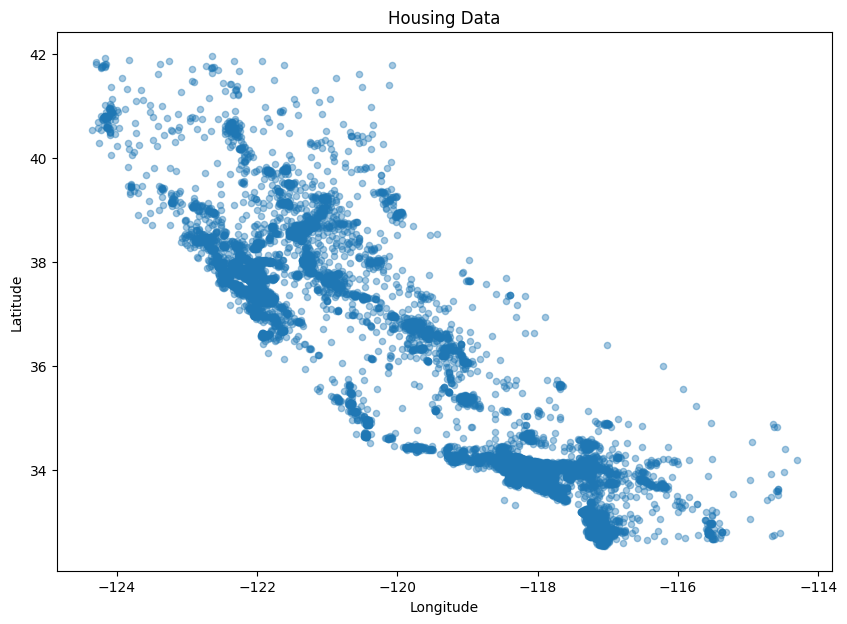

In [40]:
# let's visualize the data
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(10, 7))
plt.title('Housing Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

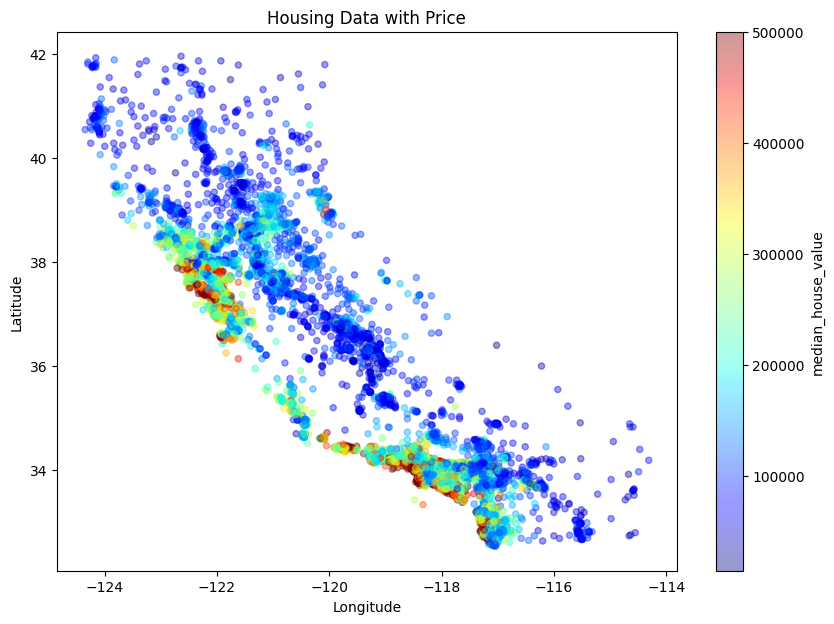

In [41]:
# let's visualize the data with price
housing.plot(kind='scatter', # using the scatter plot to visualize the data
             x='longitude',  #  longitude on the x-axis
             y='latitude',  # latitude on the y-axis
             alpha=0.4, # alpha is the transparency of the points
             figsize=(10, 7), # figure size
             c='median_house_value', # color the points by median_house_value
             cmap=plt.get_cmap('jet'), # use the jet colormap
             colorbar=True) # add a colorbar to the plot
plt.title('Housing Data with Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [42]:
# let's check the correlation between the features and the target variable
corr_matrix = housing.corr()  # calculate the correlation matrix

In [43]:
corr_matrix['median_house_value'].sort_values(ascending=False)  # sort the correlation matrix by median_house_value

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
ocean_proximity       0.076936
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

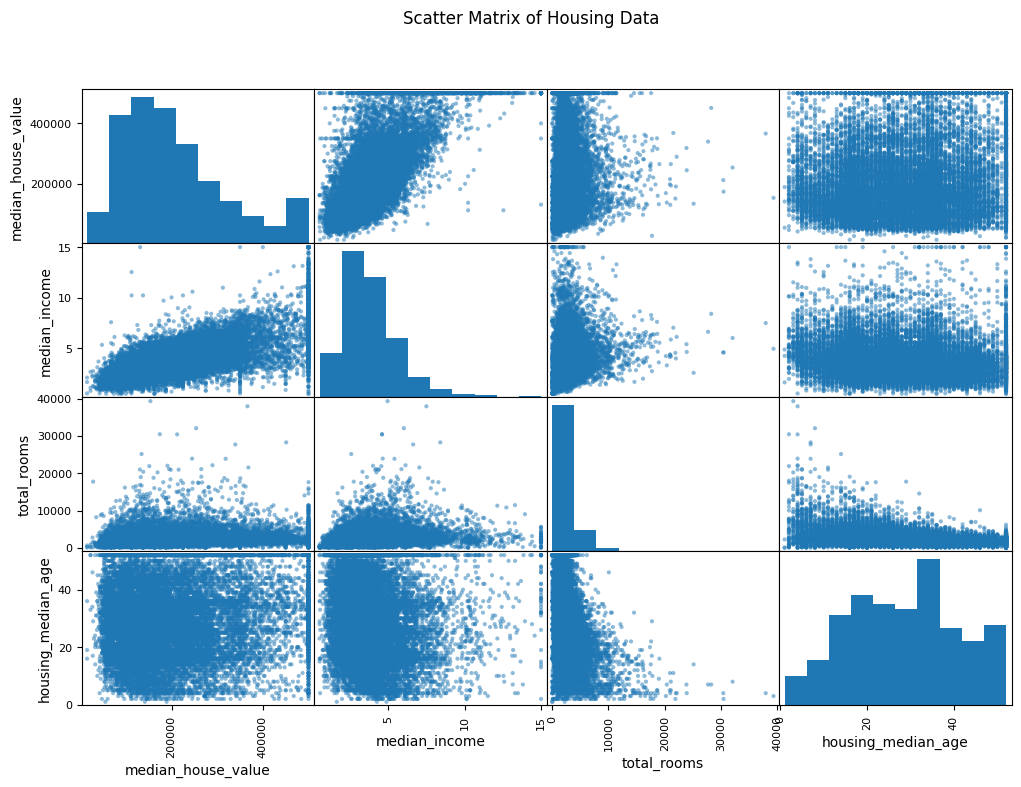

In [44]:
# let's use scatter_matrix from pandas to visualize the correlation between the features and the target variable
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age'] # select attributes to visualize
scatter_matrix(housing[attributes], figsize=(12, 8))  # create a scatter matrix of the attributes
plt.suptitle('Scatter Matrix of Housing Data')  # add a title to the plot
plt.show()  # show the plot

<Axes: xlabel='median_income', ylabel='median_house_value'>

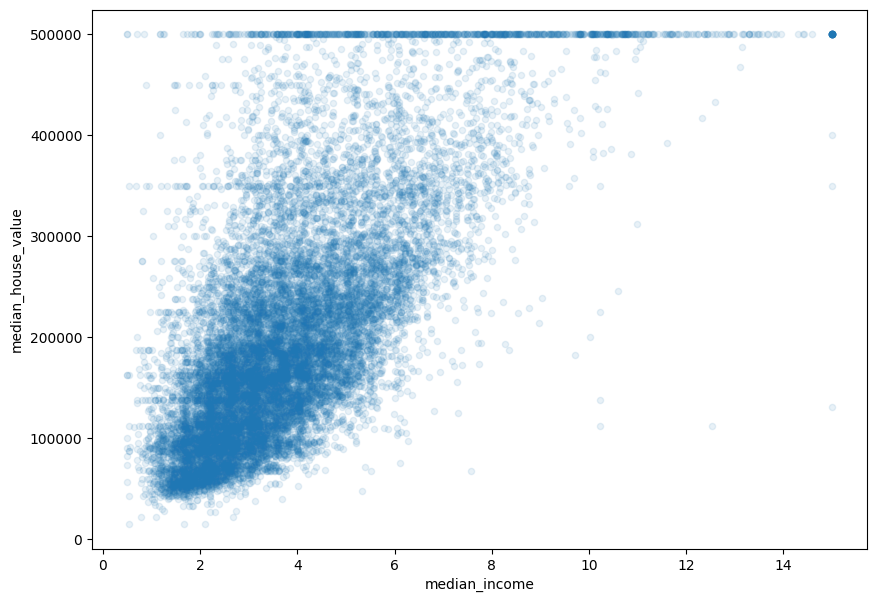

In [45]:
# let's use most correlated features to create a scatter plot
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10, 7))
# we can see that strait line is not a good fit for the data (at 500k, 450k, 350k, 280k, 220k)
# we can remove the outliers by filtering the data or apply polynomial regression

In [46]:
# Feature Engineering

# let's create a new feature called rooms_per_household
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
# let's create a new feature called bedrooms_per_room
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
# let's create a new feature called population_per_household
housing['population_per_household'] = housing['population'] / housing['households']

In [47]:
# let's check again the correlation between the features and the target variable
corr_matrix = housing.corr()  # calculate the correlation matrix
corr_matrix['median_house_value'].sort_values(ascending=False)  # sort the correlation matrix by median_house_value

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
ocean_proximity             0.076936
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [ ]:
# we find average opposite correlation between bedrooms_per_room and median_house_value (-0.25)
# average positive correlation between rooms_per_household and median_house_value (0.15)
# weak or useless correlation between population_per_household and median_house_value (0.02)

In [48]:
# Let's prepare the data for training
housing = strat_train_set.drop('median_house_value', axis=1)  # drop the target variable from the train set (aka features)
housing_labels = strat_train_set['median_house_value'].copy()  # create a copy of the target variable (aka target variable)

In [49]:
# data cleaning
imputer = SimpleImputer(strategy='median')  # create an imputer object with median strategy
imputer.fit(housing)  # fit the imputer to the training data

SimpleImputer(strategy='median')

In [50]:
imputer.statistics_ # check the statistics of the imputer

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.11900e+03,
        4.33000e+02,  1.16400e+03,  4.08000e+02,  3.54155e+00,
        1.00000e+00])

In [51]:
housing.median().values  # check the median of the training data

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.11900e+03,
        4.33000e+02,  1.16400e+03,  4.08000e+02,  3.54155e+00,
        1.00000e+00])

In [52]:
X = imputer.transform(housing)  # transform the training data using the imputer

In [53]:
housing_tr = pd.DataFrame(X, columns=housing.columns, index=housing.index)  # create a new DataFrame with the transformed data

In [54]:
# workign with categorical data
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing[['ocean_proximity']])  # fit the ordinal encoder to the categorical data

In [55]:
ordinal_encoder.categories_

[array([0, 1, 2, 3, 4], dtype=int8)]

In [56]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')
housing_cat_1hot = cat_encoder.fit_transform(housing[['ocean_proximity']])  # fit the one-hot encoder to the categorical data

In [57]:
housing_cat_1hot.shape

(16512, 5)

In [58]:
housing_cat_1hot.toarray()  # convert the sparse matrix to a dense array

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [60]:
# let's create a custom transformer to add the new features we created earlier

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6  # indices of the features we created earlier

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, bedrooms_per_room, population_per_household]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [61]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)  # transform the training data using the custom transformer

In [ ]:
# feature scaling
# this is important to scale the features so that they have similar ranges

# We can use min-max scaling or standardization
# Min-Max better for neural networks, Standardization better for linear models

In [62]:
# let's create a pipeline to preprocess the data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # impute missing values with median
    ('attribs_adder', CombinedAttributesAdder()),  # add new features
    ('std_scaler', StandardScaler())  # scale the features
])

In [63]:
housing_num_tr = num_pipeline.fit_transform(housing)  # fit the pipeline to the training data and transform it

In [64]:
# let's create a unite for numerical and categorical data
num_attribs = list(housing.select_dtypes(include=[np.number]).columns)  # select numerical attributes
cat_attribs = ['ocean_proximity']  # categorical attributes

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),  # numerical attributes
    ('cat', OneHotEncoder(), cat_attribs)  # categorical attributes
])

In [65]:
housing_prepared = full_pipeline.fit_transform(housing)

In [66]:
# finally, let's train a model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)  # fit the model to the training data

LinearRegression()

In [67]:
some_data = housing.iloc[:5]  # get some data to test the model
some_labels = housing_labels.iloc[:5]  # get the corresponding labels

some_data_prepared = full_pipeline.transform(some_data)  # transform the data using the pipeline
print("Predictions:", lin_reg.predict(some_data_prepared))  # make predictions

Predictions: [ 85464. 305288. 151936. 185864. 244328.]


In [68]:
# let's check the model's performance on the training data
housing_predictions = lin_reg.predict(housing_prepared)  # make predictions on the training data
lin_mse = mean_squared_error(housing_labels, housing_predictions)  # calculate the mean squared error
lin_rmse = np.sqrt(lin_mse)  # calculate the root mean squared error
print("Linear Regression RMSE:", lin_rmse)  # print the RMSE
# average price between 120k and 265k, so the RMSE is bad ( approx. 56% for 120k and 26% for 265k )

Linear Regression RMSE: 68628.19153967353


In [69]:
# let's try a more complex model, like Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)  # create a Decision Tree Regressor
tree_reg.fit(housing_prepared, housing_labels)  # fit the model to the training data

DecisionTreeRegressor(random_state=42)

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)  # calculate the mean squared error
tree_rmse = np.sqrt(tree_mse)  # calculate the root mean squared error
print("Decision Tree RMSE:", tree_rmse)  # print the RMSE

Decision Tree RMSE: 0.0


In [ ]:
# 0 for RMSE means that the model is overfitting the data, so we need to use cross-validation to check the model's performance

In [71]:
scores = cross_val_score(tree_reg, # model
                         housing_prepared, # features
                         housing_labels, # target variable
                         scoring='neg_mean_squared_error', # scoring metric
                         cv=10) # number of folds for cross-validation
# perform cross-validation

In [72]:
tree_rmse_scores = np.sqrt(-scores)

In [73]:
# let's create a function to display the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)  # display the scores for the Decision Tree Regressor

Scores: [74116.49099445 70863.7248923  69265.33364    70977.63400149
 68706.39316995 77335.55723998 70395.97713143 73791.30214325
 68604.13533114 71775.90876822]
Mean: 71583.2457312223
Standard deviation: 2631.2968257619495


In [ ]:
# This model worst than the Linear Regression model
# Provided next error for prices between 120k and 265k, so the RMSE is bad ( approx. 59% for 120k and 31% for 265k )

In [74]:
# le'ts check cross validation for the Linear Regression model
lin_scores = cross_val_score(lin_reg,
                              housing_prepared,
                              housing_labels,
                              scoring='neg_mean_squared_error',
                              cv=10)  # perform cross-validation

lin_rmse_scores = np.sqrt(-lin_scores)  # calculate the root mean squared error
display_scores(lin_rmse_scores)  # display the scores for the Linear Regression model

Scores: [71763.18059555 64120.6509635  67771.17124356 68635.53231824
 66836.88174972 72528.79415525 73997.08338639 68802.62688476
 66444.08406127 70140.17816333]
Mean: 69104.01835215477
Standard deviation: 2880.136324090798


In [75]:
# le's try a more complex model, like Random Forest Regressor
forest_reg = RandomForestRegressor(random_state=42)  # create a Random Forest Regressor
forest_reg.fit(housing_prepared, housing_labels)  # fit the model to the training data

RandomForestRegressor(random_state=42)

In [76]:
ran_forest_scores = cross_val_score(forest_reg,
                                housing_prepared,
                                housing_labels,
                                scoring='neg_mean_squared_error',
                                cv=10)  # perform cross-validation

ran_forest_rmse_scores = np.sqrt(-ran_forest_scores)  # calculate the root mean squared error
display_scores(ran_forest_rmse_scores)  # display the scores for the Random Forest Regressor

Scores: [51467.34587165 48730.34836278 47027.74120181 51855.1306639
 47743.16361382 51823.85179077 52479.86718537 50026.89144242
 48637.03919238 54050.82763948]
Mean: 50384.22069643794
Standard deviation: 2177.194820360801


In [ ]:
# This model is better than the Linear Regression model
# Provided next error for prices between 120k and 265k, so the RMSE is bad ( approx. 50% for 120k and 20% for 265k )

In [77]:
# fine tuning the model
# let's find the best hyperparameters for the Random Forest Regressor using Grid Search
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},  # try different number of trees and features
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}  # try different number of trees and features without bootstrap
]

forest_reg = RandomForestRegressor(random_state=42)  # create a Random Forest Regressor
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)  # create a Grid Search object

grid_search.fit(housing_prepared, housing_labels)  # fit the Grid Search object to the training data

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [78]:
best_params = grid_search.best_params_
model = grid_search.best_estimator_
print(best_params)

{'max_features': 6, 'n_estimators': 30}


In [79]:
# we can check the best hyperparameters and the best model
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)  # print the RMSE and the hyperparameters for each combination

63833.15972641643 {'max_features': 2, 'n_estimators': 3}
54967.033588558406 {'max_features': 2, 'n_estimators': 10}
52756.23099787916 {'max_features': 2, 'n_estimators': 30}
60829.73087507089 {'max_features': 4, 'n_estimators': 3}
53383.03837403472 {'max_features': 4, 'n_estimators': 10}
50690.703354060206 {'max_features': 4, 'n_estimators': 30}
59217.73263724282 {'max_features': 6, 'n_estimators': 3}
52308.845653967495 {'max_features': 6, 'n_estimators': 10}
49881.75849484328 {'max_features': 6, 'n_estimators': 30}
59224.31259479098 {'max_features': 8, 'n_estimators': 3}
51803.09318970605 {'max_features': 8, 'n_estimators': 10}
49972.906349651166 {'max_features': 8, 'n_estimators': 30}
63180.180986863015 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54143.02054641052 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60506.81313325482 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52431.213801515936 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [ ]:
# for save computation time, we can use RandomizedSearchCV instead of GridSearchCV

In [80]:
# let's check the feature importances of the best model
feature_importances = model.feature_importances_  # get the feature importances

In [81]:
feature_importances

array([7.70992463e-02, 7.56439420e-02, 4.20298361e-02, 1.98539500e-02,
       1.77538663e-02, 1.77584081e-02, 1.64129334e-02, 2.96444781e-01,
       3.53636769e-02, 6.99025537e-02, 7.82317671e-02, 1.07226996e-01,
       1.70737474e-02, 1.21219808e-01, 8.32860435e-05, 3.78735916e-03,
       4.11384312e-03])

In [83]:
extra_attribs = ['rooms_per_household', 'bedrooms_per_room', 'population_per_household']  # new features we created earlier
cat_encoder = full_pipeline.named_transformers_['cat']  # get the categorical encoder from the pipeline
cat_one_hot_attrs = list(cat_encoder.categories_[0])  # get the one-hot encoded categorical attributes
attributes = num_attribs + extra_attribs + cat_one_hot_attrs  # combine the numerical attributes, new features and one-hot encoded categorical attributes

sorted(zip(feature_importances, attributes), reverse=True)  # sort the feature importances and attributes

[(0.29644478093514837, 'median_income'),
 (0.12121980791300327, 1),
 (0.10722699578980219, 'population_per_household'),
 (0.0782317670664911, 'bedrooms_per_room'),
 (0.0770992462826973, 'longitude'),
 (0.0756439420106587, 'latitude'),
 (0.0699025536640932, 'rooms_per_household'),
 (0.04202983610042008, 'housing_median_age'),
 (0.03536367685038189, 'ocean_proximity'),
 (0.01985394997988737, 'total_rooms'),
 (0.017758408064372348, 'population'),
 (0.01775386626179381, 'total_bedrooms'),
 (0.01707374739030328, 0),
 (0.016412933367552215, 'households'),
 (0.0041138431188506245, 4),
 (0.003787359161031297, 3),
 (8.328604351306701e-05, 2)]

In [84]:
# let's evaluate the model on the test set
final_model = grid_search.best_estimator_  # get the best model from the Grid Search
X_test = strat_test_set.drop('median_house_value', axis=1)  # drop the target variable from the test set
y_test = strat_test_set['median_house_value'].copy()  # create a copy of the target variable

X_test_prepared = full_pipeline.transform(X_test)  # transform the test set using the pipeline
final_predictions = final_model.predict(X_test_prepared)  # make predictions on the test set

final_mse = mean_squared_error(y_test, final_predictions)  # calculate the mean squared error
final_rmse = np.sqrt(final_mse)  # calculate the root mean squared error
print("Final RMSE on the test set:", final_rmse)  # print the RMSE on the test set

Final RMSE on the test set: 47736.91314339482


In [85]:
# we can use confidence intervals to estimate the uncertainty of the predictions
confidence = 0.95  # confidence level
squared_errors = (final_predictions - y_test) ** 2  # calculate the squared errors
result = np.sqrt(stats.t.interval(
    confidence,
    len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)
))

print("Confidence interval for the final RMSE:", result)  # print the confidence interval for the RMSE (lower, upper)

Confidence interval for the final RMSE: [45743.75190105 49650.12502437]


In [ ]:
# finally, let's save the model
joblib.dump(final_model, 'final_model.pkl')  # save the final model to a file